# Explore here

In [1]:
!pip install regex  wordcloud unidecode nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.1/785.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [25]:
%pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 11.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import imblearn.under_sampling 

Paso 1. Lectura del conjunto de datos¶

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
df.shape

(2999, 2)

Eliminar duplicados

In [5]:
# Verificar si hay filas duplicadas en el DataFrame
filas_duplicadas = df.duplicated().sum()
filas_duplicadas

630

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
#se eliminaron 630 url
df.shape

(2369, 2)

In [8]:
# Comporbamos si nuestro dataset esta balanceado
df.is_spam.value_counts()
print(f'Se enceuntra desbalanceado:  {df.is_spam.value_counts()}')

Se enceuntra desbalanceado:  is_spam
False    2125
True      244
Name: count, dtype: int64


Paso 2: Procesamiento de datos

Transformamos nuestras dos categorías spam y ham en valores numéricos (0 y 1) ya que este como la mayoría de los modelos, no trabajan con variables de clase categóricas:

In [9]:
#Transformación categórica a numérica

df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


PROCESADO DEL TEXTO

Para poder entrenar el modelo es necesario aplicar antes un proceso de transformación al texto.

In [10]:


def preprocess_url(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

   # Tokenización del texto
    tokens = word_tokenize(text)
    # Eliminación de palabras cortas para reducir el vocabulario
    tokens = [token for token in tokens if len(token)>3]
    # Eliminación de las stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # stemmer de palabras

    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    


    # Lematización de palabras
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.lemmatize(token) for token in tokens]
    

    return ' '.join(tokens)


In [11]:
# Ejemplo de aplicación de la función de preprocesado para un url aleatorio
url_aleatorio = df.sample(1).url.values[0]
print(f'url antes de ser preprocesado:\n {url_aleatorio}')
url_aleatorio_prepro = preprocess_url(url_aleatorio)
print('-'*50)
print(f'Url tras ser preprocesado:\n {url_aleatorio_prepro}')

url antes de ser preprocesado:
 https://seattle.eater.com/2020/6/18/21293916/seattle-protest-zone-chop-chaz-capitol-hill-food-eating
--------------------------------------------------
Url tras ser preprocesado:
 http seattl eater seattl protest zone chop chaz capitol hill food eat


In [12]:
# Aplicamos el preprocesado a todos los textos del dataset
df['url_prepro'] = df.url.progress_apply(preprocess_url)

100%|██████████| 2369/2369 [00:00<00:00, 2454.45it/s]


Comprobación de duplicados

In [13]:
# Comprobación de posibles url duplicados
print(f'Número de url duplicados: {df.url_prepro.duplicated().sum()}')

Número de url duplicados: 185


In [14]:
# Eliminar tweets que tras ser preprocesados han quedado igual
df.drop_duplicates(subset='url_prepro', inplace=True)
print(f'El dataset se compone de un total de {df.shape[0]} url.')

El dataset se compone de un total de 2184 url.


In [15]:
# Comprobación de valores faltantes
df['url_prepro'].isna().sum()

0

Tras obtener los Tokens representamos una nube de palabras. Esta se enceuntra compuesta por las palabras que integran un texto, donde el tamaño de cada palabra indica su frecuencia o importancia en dicho texto.

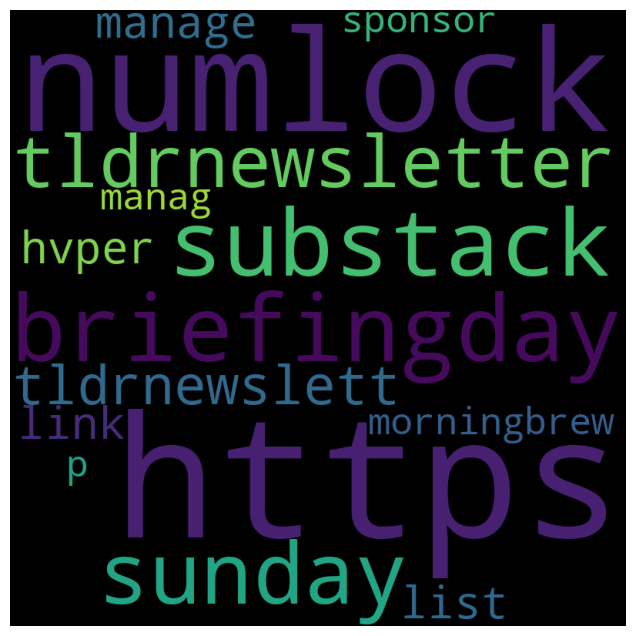

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Supongamos que data_fn es tu DataFrame con una columna 'url_pre' y 'is_spam'
data_fn_1 =df[df['is_spam'] == 1]
data_fn_0 = df[df['is_spam'] == 0]

#Obtenemos la nube de palabras
wordcloud_spam = WordCloud(width = 800, height = 800, background_color = "black", max_words = 15, min_font_size = 10, random_state = 42)\
    .generate(str(data_fn_1))

#Graficamos la nube de palabras
fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_spam)
plt.axis("off")
plt.show()


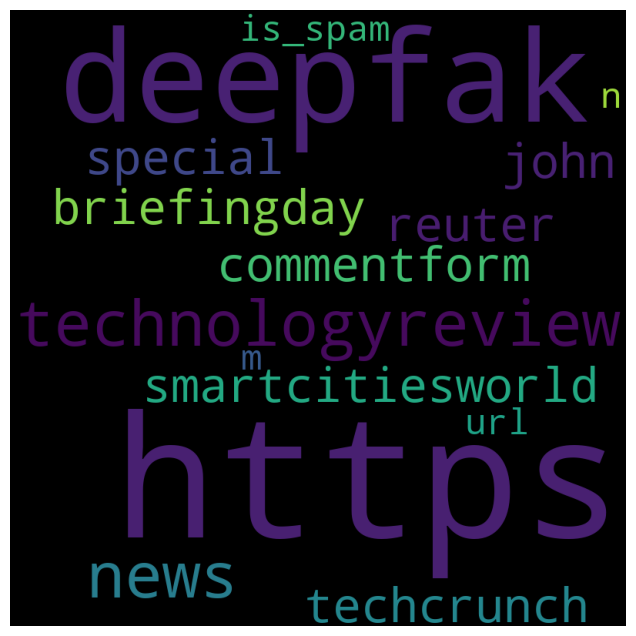

In [17]:
#Obtenemos la segunda nube de palabras
wordcloud_spam = WordCloud(width = 800, height = 800, background_color = "black", max_words = 15, min_font_size = 10, random_state = 42)\
    .generate(str(data_fn_0))

#Gráficamos la segunda nube de palabras obtenida
fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_spam)
plt.axis("off")
plt.show()

División en conjuntos de entrenamiento

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['url_prepro'], df['is_spam'], test_size=0.2, random_state=42)

El último paso antes de entrenar el modelo es convertirlo en números, ya que los modelos no pueden entrenar con categorías textuales

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Crear la versión vectorizada de los textos desechando palabras que aparezcan en menos del 0.1% de los documentos
vectorizer = TfidfVectorizer(min_df=0.001)
X_train_num = vectorizer.fit_transform(X_train)
X_test_num = vectorizer.transform(X_test)

In [21]:
len(X_train)*0.001

1.747

In [22]:
vectorizer.get_feature_names_out()

array(['abacu', 'abbott', 'abcnew', ..., 'zone', 'zoom', 'zoox'],
      dtype=object)

In [23]:
X_train_num.toarray().shape

(1747, 1448)

Como los datos se encuentran desbalanceados realizamos la siguiente corrección para subsanar dicho problema.

In [26]:
from imblearn.under_sampling import RandomUnderSampler

# Aplicar submuestreo para resolver el desbalanceo
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_num, y_train)

4.Modelización y métricas

Inicialización y entrenamiento del modelo

In [27]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_resampled, y_resampled)

SVC(kernel='linear', random_state=42)

In [28]:
y_pred = model.predict(X_test_num)
y_pred

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90       392
           1       0.35      0.80      0.49        45

    accuracy                           0.83       437
   macro avg       0.66      0.82      0.69       437
weighted avg       0.91      0.83      0.85       437



OPTIMIZACIÓN DEL MODELO

In [30]:
import numpy as np
from sklearn.model_selection import GridSearchCV

hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

# We initialize the random search
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)
print(grid)

GridSearchCV(cv=10, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')


In [31]:
grid.fit(X_resampled, y_resampled)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
700 fits failed out of a total of 3500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
700 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.l

In [32]:
opt_model = grid.best_estimator_
opt_model.fit(X_resampled, y_resampled)
y_pred = opt_model.predict(X_test_num)

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
opt_model = SVC(C = 10, degree = 1, gamma = "scale", kernel = "rbf", random_state = 42)
opt_model.fit(X_resampled, y_resampled)
y_pred = opt_model.predict(X_test_num)

In [35]:
accuracy_score(y_test, y_pred)

0.8901601830663616

In [36]:
print(classification_report(y_test, y_pred))
#grabar este modelo

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       392
           1       0.48      0.71      0.57        45

    accuracy                           0.89       437
   macro avg       0.72      0.81      0.75       437
weighted avg       0.91      0.89      0.90       437



Probamos con otro modelo en este caso Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
clf = LogisticRegression().fit(X_resampled.toarray(), y_resampled)
y_pred = clf.predict(X_test_num.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       392
           1       0.38      0.73      0.50        45

    accuracy                           0.85       437
   macro avg       0.67      0.80      0.71       437
weighted avg       0.91      0.85      0.87       437



OPTIMIZACIÓN DEL MODELO LogisticRegression

In [39]:
import numpy as np
from sklearn.model_selection import GridSearchCV
#Buscamos los mejores hiperparametros
hyperparams = {
    "penalty": ['l1', 'l2', 'elasticnet'],
    "dual": [False],
    "tol": [0.0001],
    "C": [1.0],
    "fit_intercept": [True],
    "intercept_scaling": [1.0],
    "class_weight": [None],
    "random_state": [None],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    "max_iter": [100],
    "multi_class": ['auto', 'ovr', 'multinomial'],
    "verbose": [0],
    "warm_start": [False],
    "n_jobs": [None],
    "l1_ratio": [None]
}

# Inicializamos el random
grid = GridSearchCV(clf, hyperparams, scoring = "accuracy", cv = 10)
print(grid)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1.0], 'class_weight': [None], 'dual': [False],
                         'fit_intercept': [True], 'intercept_scaling': [1.0],
                         'l1_ratio': [None], 'max_iter': [100],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'n_jobs': [None],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.0001], 'verbose': [0],
                         'warm_start': [False]},
             scoring='accuracy')


In [40]:
#Obtenemos los mejores hiperparámetros
grid.fit(X_resampled, y_resampled)

print(f"Best hyperparameters: {grid.best_params_}")

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
330 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1

In [41]:
# Obtemos el mejor modelo entrenado
best_model = grid.best_estimator_.fit(X_resampled.toarray(), y_resampled)

In [42]:
y_pred = best_model.predict(X_test_num.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       392
           1       0.38      0.78      0.51        45

    accuracy                           0.85       437
   macro avg       0.68      0.82      0.71       437
weighted avg       0.91      0.85      0.87       437



In [ ]:
#Guardamos el mejor modelo, dicho model fue el SVC Optimizado
from pickle import dump

dump(opt_model, open("../models/SVC_Opt_42.sav", "wb"))